In [61]:
%matplotlib widget

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Params

In [63]:
WIDTH = 32
TIMESTEPS = 32

# Stimuli generation

In [64]:
images = np.zeros((TIMESTEPS, WIDTH))
for i in range(TIMESTEPS):
    images[i,i:i+2] = 1.0
    #images[i,i+4:i+6] = 1.0

Text(0, 0.5, 'T')

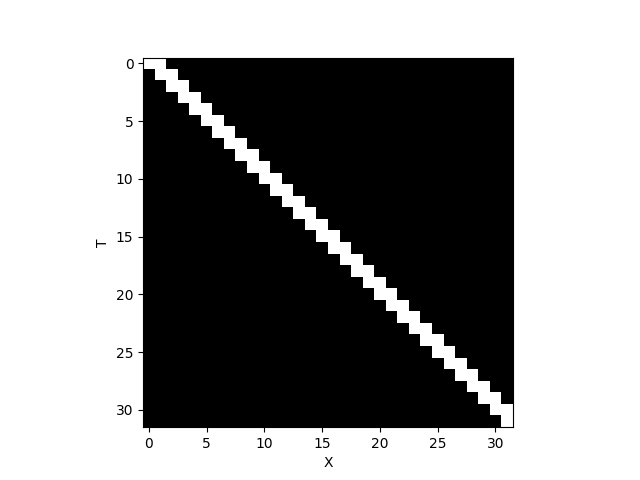

In [71]:
fig, axis = plt.subplots()
axis.imshow(images, cmap="gray")

axis.set_xlabel("X")
axis.set_ylabel("T")

# High-pass filters

Text(0.5, 0, 'T')

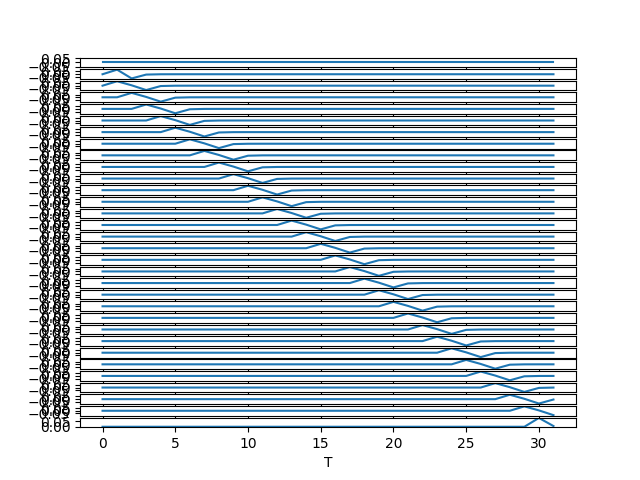

In [72]:
# Where is ESTMD
ESTMD_X = 16

LPF_TAU = 0.4

# EMA time constant
LPF_K = np.exp(-1 / LPF_TAU)

lpf = np.zeros((TIMESTEPS, WIDTH))
f = np.zeros((TIMESTEPS, WIDTH))
for t in range(1, TIMESTEPS):
    lpf[t] = (LPF_K * lpf[t - 1]) + ((1.0 - LPF_K) * images[t])
    f[t] = (images[t] - lpf[t])

fig, axes = plt.subplots(WIDTH, sharex=True)
for i, a in enumerate(axes):
    a.plot(f[:,i])
axes[-1].set_xlabel("T")

# Half-wave rectification

Text(0.5, 0, 'T')

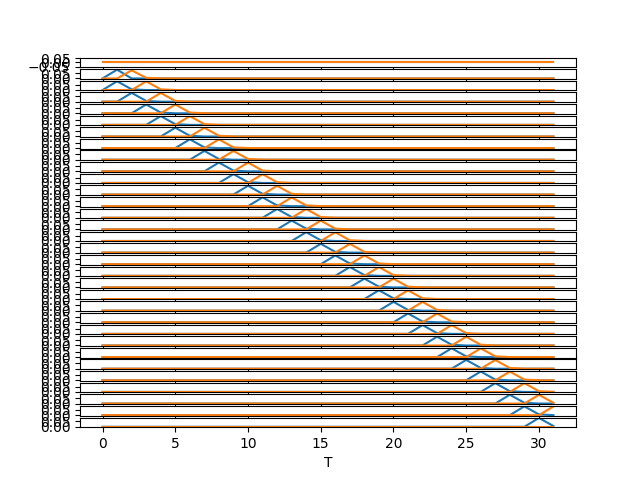

In [73]:
on_f = np.maximum(f, 0.0)
off_f = -np.minimum(f, 0.0)

fig, axes = plt.subplots(WIDTH, sharex=True)
for i, a in enumerate(axes):
    a.plot(on_f[:,i])
    a.plot(off_f[:,i])
axes[-1].set_xlabel("T")

# FDSR

Text(0.5, 0, 'T')

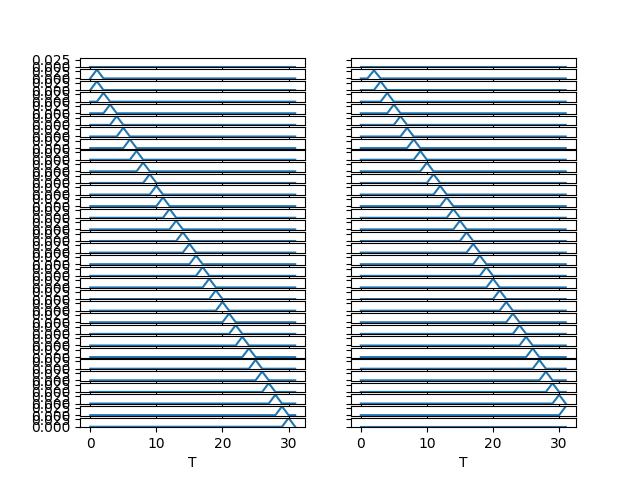

In [74]:
FDSR_TAU_FAST = 1
FDSR_TAU_SLOW = 100

FSR_K_FAST = np.exp(-1 / FDSR_TAU_FAST)
FSR_K_SLOW = np.exp(-1 / FDSR_TAU_SLOW)

a_on = np.zeros((TIMESTEPS, WIDTH))
a_off = np.zeros((TIMESTEPS, WIDTH))
for t in range(1, TIMESTEPS):
    # **TODO** independent of time, could be matrix
    k_on = np.where((on_f[t] - on_f[t - 1]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    k_off = np.where((off_f[t] - off_f[t - 1]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    
    a_on[t] = ((1.0 - k_on) * on_f[t]) + (k_on * a_on[t - 1]) 
    a_off[t] = ((1.0 - k_off) * off_f[t]) + (k_off * a_off[t - 1]) 

# Rectify
a_on = np.maximum(0.0, on_f - a_on)
a_off = np.maximum(0.0, off_f - a_off)

fig, axes = plt.subplots(WIDTH, 2, sharex=True, sharey=True)
for i in range(WIDTH):
    axes[i,0].plot(a_on[:,i])
    axes[i,1].plot(a_off[:,i])

axes[-1, 0].set_xlabel("T")
axes[-1, 1].set_xlabel("T")

# Recombine

Text(0.5, 0, 'T')

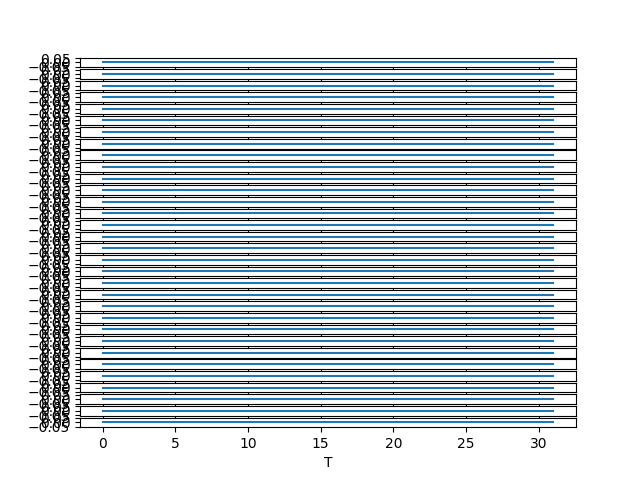

In [75]:
OFF_TAU = 25
OFF_K = np.exp(-1 / OFF_TAU)

off_filter = np.zeros((TIMESTEPS, WIDTH))
output = np.zeros((TIMESTEPS, WIDTH))

for t in range(1, TIMESTEPS):
    off_filter[t] = ((1.0 - OFF_K) * a_off[t]) + (OFF_K * off_filter[t - 1]) 
    output[t] = off_filter[t] * a_on[t]

fig, axes = plt.subplots(WIDTH, sharex=True)
for i, a in enumerate(axes):
    a.plot(output[:,i])
axes[-1].set_xlabel("T")